['JSWSTEEL', 'TATASTEEL']
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.

,gmean,amean,std,shrp,srt,k,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019,2020
,-0.02042,-0.02081,0.001366,-0.9597,-1.029,1.74,-1.023,-1.023,0.02034,2020-03-09/2020-03-16,0.02034,2020-03-09/2020-03-16,1/3/0.25,0,-0.03224


<Figure size 576x432 with 0 Axes>

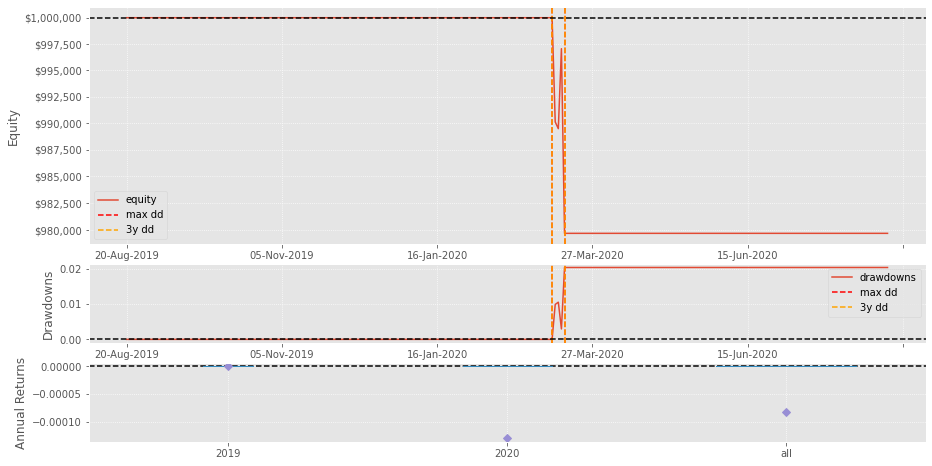

In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Agg')
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import scipy.stats
import os
from types import SimpleNamespace
from evaluate_pairs import evaluate_pairs
import pyqstrat as pq

pq.set_defaults()

def zscore_indicator(symbol, timestamps, indicators, strategy_context):
    residuals = indicators.residuals
    r = pd.Series(residuals).rolling(window = 130) #tune this parameter
    mean = r.mean()
    std = r.std(ddof = 0)
    zscore = (residuals - mean) / std
    zscore = np.nan_to_num(zscore)
    return zscore

# CHECK THIS FUNCTION LOGIC
def pair_strategy_signal(contract_group, timestamps, indicators, parent_signals, strategy_context):
    zscore = indicators.zscore
    # symbol_1 = contract_group.get_contract()
    # print(symbol_1)
    symbol_list = g_pair
    # symbol_list.remove(symbol_1)
    print(zscore)
    signal = np.where(zscore > 2.5, -2, 0)
    signal = np.where(zscore < -2.5, 2, signal)

    # target
    signal = np.where((zscore < 1) & (zscore > 0), -1, signal)
    signal = np.where((zscore > -1) & (zscore < 0), 1, signal)

    # stoploss
    signal = np.where((zscore > 3), -3, signal)
    signal = np.where((zscore < -3), 3, signal)

    if contract_group.get_contract(symbol_list[1]): signal = -1. * signal
    return signal

# check stoploss and target implementation
def pair_trading_rule(contract_group, i, timestamps, indicators, signal, account, strategy_context):
    timestamp = timestamps[i]
    curr_pos = account.position(contract_group, timestamp)
    signal_value = signal[i]
    risk_percent = 0.1

    orders = []
    # symbol = contract_group.name
    contract = contract_group.get_contract(g_pair[0])
    # if contract is None:
    #     contract = pq.Contract.create(symbol, contract_group = contract_group)



    # s1_symbol = g_pair[0]
    # s2_symbol = g_pair[1]
    # s1_contract = s1_contract_group.get_contract(s1_symbol)
    # s2_contract = s2_contract_group.get_contract(s2_symbol)
    # if s1_contract is None:
    #     s1_contract = pq.Contract.create(s1_symbol, contract_group = s1_contract_group)
    # if s2_contract is None:
    #     s2_contract = pq.Contract.create(s2_symbol, contract_group = s2_contract_group)

    if math.isclose(curr_pos, 0):
        if signal_value == 2 or signal_value == -2 :
            curr_equity = account.equity(timestamp)
            order_qty = np.round(curr_equity * risk_percent / indicators.Close[i] * np.sign(signal_value))
            trigger_price = indicators.Close[i]
            reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
            orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))

        if signal_value == 3 or signal_value == -3:
            j = i-1
            order_triggered_flag = False
            # while(j>=0):
            #     prev_signal_value = signal[j]
            #     if(prev_signal_value == 3 or prev_signal_value == -3):
            #         order_qty = -curr_pos
            #         reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            #         orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))
            #         order_triggered_flag = True
            #         break
            #     if(prev_signal_value == 2 or prev_signal_value == -2):
            #         order_qty = -curr_pos
            #         reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            #         orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))
            #         order_triggered_flag = True
            #         break

            if(order_triggered_flag == False):
                curr_equity = account.equity(timestamp)
                order_qty = np.round(curr_equity * risk_percent / indicators.Close[i] * np.sign(signal_value) * -1)
                trigger_price = indicators.Close[i]
                reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
                orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))
    else:
        # check this logic
        if (curr_pos > 0 and signal_value == 1) or (curr_pos < 0 and signal_value == -1):
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))

        if (curr_pos > 0 and signal_value == 3) or (curr_pos < 0 and signal_value == -3):
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            orders.append(pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))

    # print(orders)
    return orders


def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
    trades = []
    timestamp = timestamps[i]
    for order in orders:
        try:
            print(order)
            trade_price = np.nan
            contract_group = order.contract.contract_group
            ind = indicators[contract_group]
            o, h, l, c = ind.Open[i], ind.High[i], ind.Low[i], ind.Close[i]
            if isinstance(order, pq.MarketOrder):
                trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
            else:
                raise Exception(f'unexpected order type: {order}')

            if np.isnan(trade_price): continue
            trade = pq.Trade(order.contract, order, timestamp, order.qty, trade_price, commission = 0, fee = 0)
            order.status = 'filled'

            trades.append(trade)
        except:
            print("empty order")

    return trades


def get_price(contract, timestamps, i, strategy_context):
    # symbol = contract.symbol
    if contract.symbol == g_pair[0]:
        return strategy_context.s1_price[i]
    elif contract.symbol == g_pair[1]:
        return strategy_context.s2_price[i]
    raise Exception(f'Unknown symbol: {contract.symbol}')


def build_strategy(pair, s1_contract_group, s2_contract_group):
    end_date = date.today() + relativedelta(days = 1)
    start_date = end_date - relativedelta(years = 1)



    s1_prices = pd.read_csv("stock_data/" + pair[0] + "_" + str(start_date) + "_" + str(end_date) + ".csv")
    s2_prices = pd.read_csv("stock_data/" + pair[1] + "_" + str(start_date) + "_" + str(end_date) + ".csv")


    pair_params = pairs_data[pairs_data['Stock_X'].isin(pair) & pairs_data['Stock_Y'].isin(pair)]
    # print(pair_params)
    p_value = pair_params['P-Value from ADF test']
    std_err_residuals = pair_params['std_error_of_residuals']
    slope = pair_params['Slope']
    intercept = pair_params['Intercept']
    # latest_residual = pair_params['latest_residual']
    # std_err_zscore = pair_params['std_err_zscore']
    # print(std_err_zscore)
    residuals_df = pd.read_csv('pair_trading_data/' + pair[0] + "_" + pair[1] + ".csv") # read according to the correct order. This is test
    residuals = residuals_df['Residuals']
    timestamps = pd.to_datetime(residuals_df['Date'])
    timestamps = timestamps.values
    pair_z_score = zscore_indicator(None, None,SimpleNamespace(residuals = residuals), None)
    # pair_z_score_df = pd.DataFrame(pq.TimeSeries('residuals', timestamps, residuals))
    # print(pair_z_score_df)

    # print([pq.TimeSeries('residuals', timestamps, residuals)])
    # residual_subplot = pq.Subplot([pq.TimeSeries('residuals', timestamps, residuals)], ylabel = 'Ratio')
    # pair_z_score_df.plot(legend = False)
    # zscore_subplot = pq.Subplot([pq.TimeSeries('zscore', timestamps, pair_z_score)], ylabel = 'ZScore')


    # signal = pair_strategy_signal(None, timestamps, SimpleNamespace(zscore = pair_z_score), None, None)
    # signal_subplot = pq.Subplot([pq.TimeSeries('signal', timestamps, signal)], ylabel = 'Signal')
    # plot = pq.Plot([residual_subplot, zscore_subplot, signal_subplot], title = 'temp')
    # plot.show()
    # print(signal)


    strategy_context = SimpleNamespace(s1_price = s1_prices.Close.values, s2_price = s2_prices.Close.values)
    strategy = pq.Strategy(timestamps, [s1_contract_group, s2_contract_group], get_price, trade_lag = 0, strategy_context = strategy_context)
    for tup in [(s1_contract_group, s1_prices), (s2_contract_group, s2_prices)]:
        for column in ['Open', 'High', 'Low', 'Close']:
            strategy.add_indicator(column, tup[1][column].values, contract_groups = [tup[0]])


    strategy.add_indicator('residuals', residuals)
    strategy.add_indicator('zscore', zscore_indicator, depends_on = ['residuals'])
    strategy.add_signal('pair_strategy_signal', pair_strategy_signal, depends_on_indicators = ['zscore'])
    strategy.add_rule('pair_trading_rule', pair_trading_rule, signal_name = 'pair_strategy_signal', sig_true_values = [-3, -2, -1, 1, 2, 3])
    strategy.add_market_sim(market_simulator)
    return strategy


# TATAMOTORS
pairs = [['JSWSTEEL', 'TATASTEEL']]
# pairs = [['JSWSTEEL', 'TATASTEEL'],['TATAMOTORS', 'MOTHERSUMI'], ['HDFCBANK', 'ICICIBANK'], ['INFY', 'TCS'], ['HDFCBANK', 'KOTAKBANK']]
# df_stock_1['timestamp'] = pd.to_datetime(df_stock_1.Date)
# df_stock_2['timestamp'] = pd.to_datetime(df_stock_2.Date)
#
# print(df_stock_2)
#
# print(type(s2_contract_group))
# ratio = df_stock_1.Close/df_stock_2.Close
# print(ratio)
pairs_data = evaluate_pairs(pairs)
s1_contract_group = pq.ContractGroup.create('s1')
s2_contract_group = pq.ContractGroup.create('s2')
# print(pairs_data)
portfolio = pq.Portfolio()
for pair in pairs:
    global g_pair
    g_pair = pair
    print((pair))
    # contract = contract_group.get_contract(g_pair[0])

    symbol_1_contract = s1_contract_group.get_contract(pair[0])
    if symbol_1_contract is None:
        symbol_1_contract = pq.Contract.create(pair[0], s1_contract_group)

    symbol_2_contract = s2_contract_group.get_contract(pair[1])
    if symbol_2_contract is None:
        symbol_2_contract = pq.Contract.create(pair[1], s2_contract_group)



    # symbol_2_contract = pq.Contract.create(pair[1], s2_contract_group)

    strategy = build_strategy(pair, s1_contract_group, s2_contract_group)
    strategy_name = 'pair_strategy_' + str(pair[0]) + "_" + str(pair[1])

    portfolio.add_strategy(strategy_name, strategy)

portfolio.run()
# strategy.plot(primary_indicators = ['Close'], secondary_indicators = ['zscore'])
strategy.evaluate_returns()
